# Логистическая регрессия

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)
np.random.seed(0)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [32]:
from sklearn.base import BaseEstimator, ClassifierMixin
np.random.seed(0)


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty='l2'):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        #словарь для выбора функции регуляризации
        param_penalti = {
            'l2': self._grad_l2,
            'l1': self._grad_l1
        }

        try:
            self._gradient = param_penalti[penalty]
        except KeyError as er:
            raise ValueError("penalty mast be 'l1' or 'l2'")

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self._theta = None
        self._theta_path = [] # как меняется theta с каждым пробегом
        self.rss = [] 

    def _grad_l2(self, theta, xi, yi):
        """
        L2 регуляризация
        """
        gradient, delta = self._grad(theta, xi, yi)
        gradient = gradient + self.C * theta
        return gradient, delta

    def _grad_l1(self, theta, xi, yi):
        """
        L1 регуляризация
        """
        gradient, delta = self._grad(theta, xi, yi)
        gradient = gradient + self.C * np.sign(theta)
        return gradient, delta
    
    @staticmethod
    def _grad(theta, xi, yi):
        """
        Рассчет градиента
        """
        
        predict = np.dot(xi, theta)
        predict_norm = 1 / (1 + np.exp(-predict)) # это лучше, чем
#         predict_norm = (1+np.sign(predict))/2
        delta = predict_norm - yi
        gradient = np.dot(xi.T, delta)
        return gradient, delta
    
    def _calc_theta(self,_theta, X, y):
        """
        Поиск theta
        """
        theta = _theta
        n = X.shape[0] # размер выборки
        X_b = np.hstack((np.ones((n, 1)), X)) # добавляем столбец 1
        m = X_b.shape[1] # число признаков
        for epoch in range(self.max_epoch):
            p = np.random.permutation(n) # задаем случайный порядок элементов выборки
            delta = 0
            for idx in p:
                xi = X_b[[idx], :] # выбираем x
                yi = y[idx] # и у
                gradient, _delta = self._gradient(theta, xi, yi) # считаем градиент и разницу
                delta += np.square(_delta[0]) # сумма квадратов ошибок
                theta = theta - 2. / n * self.alpha * gradient # сдвиг theta
                self._theta_path.append(theta) # запоминаем изменения
            self.rss.append(delta) # значение функции потерь на i итеррации
        self.rss = np.array(self.rss).reshape(len(self.rss))
        self._theta = theta # запоминаем theta

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        
        theta = np.random.randn(X.shape[1]+1, 1) # задаем случайно theta
        self._calc_theta(theta,X,y) # и рассчитываем её
        
        return self

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''

        theta = self._theta # мы ведь дообучаем? передаем рабочую theta
        self._calc_theta(theta,X,y)

        return self

    def _regr(self, X):
        """
        Считаем у
        """
        n = X.shape[0]
        X_b = np.hstack((np.ones((n, 1)), X))
        return X_b.dot(self._theta)

    def predict(self, X):
        '''
        Возвращение метки класса
        '''

        y_hat = np.sign(self._regr(X)) # знак укажет мы с одной или с другой стороны от прямой
        y_hat[y_hat < 0] = 0 # определяем класс 0 или 1
        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''

        y = 1/(1+np.exp(self._regr(X))) 
        y_hat_proba = np.hstack((y, 1-y)) # класс0 = 1 - класс1

        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

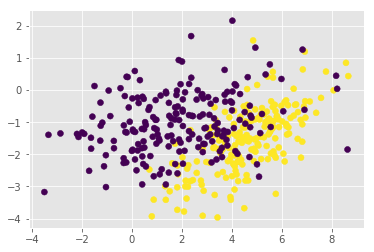

In [29]:
C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:, 0], X[:, 1], c=y)

Разделим на обучаемую и тестовую выборки

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

Обучаем

In [33]:
max_epoch = 100
model = MySGDClassifier(C=0, max_epoch=max_epoch, alpha=1, penalty='l2') # отключим регуляризацию)))
model.fit(X_test, y_test)
model._theta

array([[-5.64301649],
       [ 1.29644052],
       [-1.23485751]])

In [7]:
model.score(X_test, y_test)

0.905

(-5.079296238869098, 2.176141863312651)

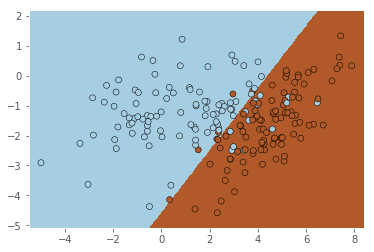

In [8]:
fig, ax = plt.subplots()

# рисуем области
h = .02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# наносим точки
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test,
           edgecolors='k', cmap=plt.cm.Paired)


ax.axes.set_xlim(x_min, x_max)
ax.axes.set_ylim(X[:, 1].min()-.5, X[:, 1].max()+0.5)

In [9]:
y_p = model.predict_proba(X_test)[:,1]
y_p[y_p>=0.5] = 1
y_p[y_p<0.5] = 0
np.vstack((y_p,y_test)).T

array([[1., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [1., 1.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [0., 0.

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

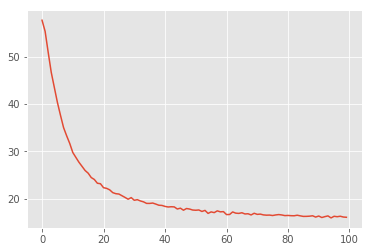

In [34]:
fig, ax = plt.subplots()

ax.plot(np.arange(len(model.rss)), model.rss)

Как менялась линия разделения

(-5.079296238869098, 2.176141863312651)

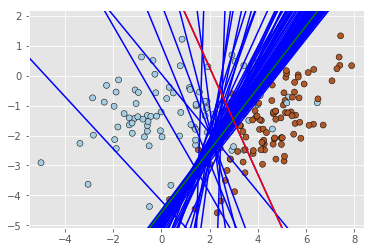

In [11]:
num_lines = 100 # сколько линий рисовать
fig, ax = plt.subplots()

# нарисуем точки
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test,
           edgecolors='k', cmap=plt.cm.Paired)

x_min, x_max = X[:, 0].min()-.5, X[:, 0].max()+0.5
x_pr = np.array([x_min, x_max])

# а теперь линии
for i, theta in enumerate(model._theta_path[::int(max_epoch*y.size/num_lines/2)]):
    y_pr = -(theta[1, 0] * x_pr + theta[0, 0]) / theta[2, 0]
    ax.plot(x_pr, y_pr, 'b')
    
    
# красным откуда начинали
theta = model._theta_path[0]
y_pr = -(theta[1, 0] * x_pr + theta[0, 0]) / theta[2, 0]
ax.plot(x_pr, y_pr, 'r')

# зеленым к чему пришли
theta = model._theta_path[-1]
y_pr = -(theta[1, 0] * x_pr + theta[0, 0]) / theta[2, 0]
ax.plot(x_pr, y_pr, 'g')


ax.axes.set_xlim(x_min, x_max)
ax.axes.set_ylim(X[:, 1].min()-.5, X[:, 1].max()+0.5)

Нарисуем функции потерь в зависимости от регуляризации, C, alpha, max_epoch

draw for C= 1000000.0
draw for reg= none
draw for reg= l1


/home/necromant/.virtualenvs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


draw for reg= l2


/home/necromant/.virtualenvs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in multiply
/home/necromant/.virtualenvs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in subtract
/home/necromant/.virtualenvs/datascience/lib/python3.6/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


draw for C= 10
draw for reg= none
draw for reg= l1
draw for reg= l2
draw for C= 1
draw for reg= none
draw for reg= l1
draw for reg= l2
draw for C= 0.1
draw for reg= none
draw for reg= l1
draw for reg= l2
draw for C= 0.01
draw for reg= none
draw for reg= l1
draw for reg= l2


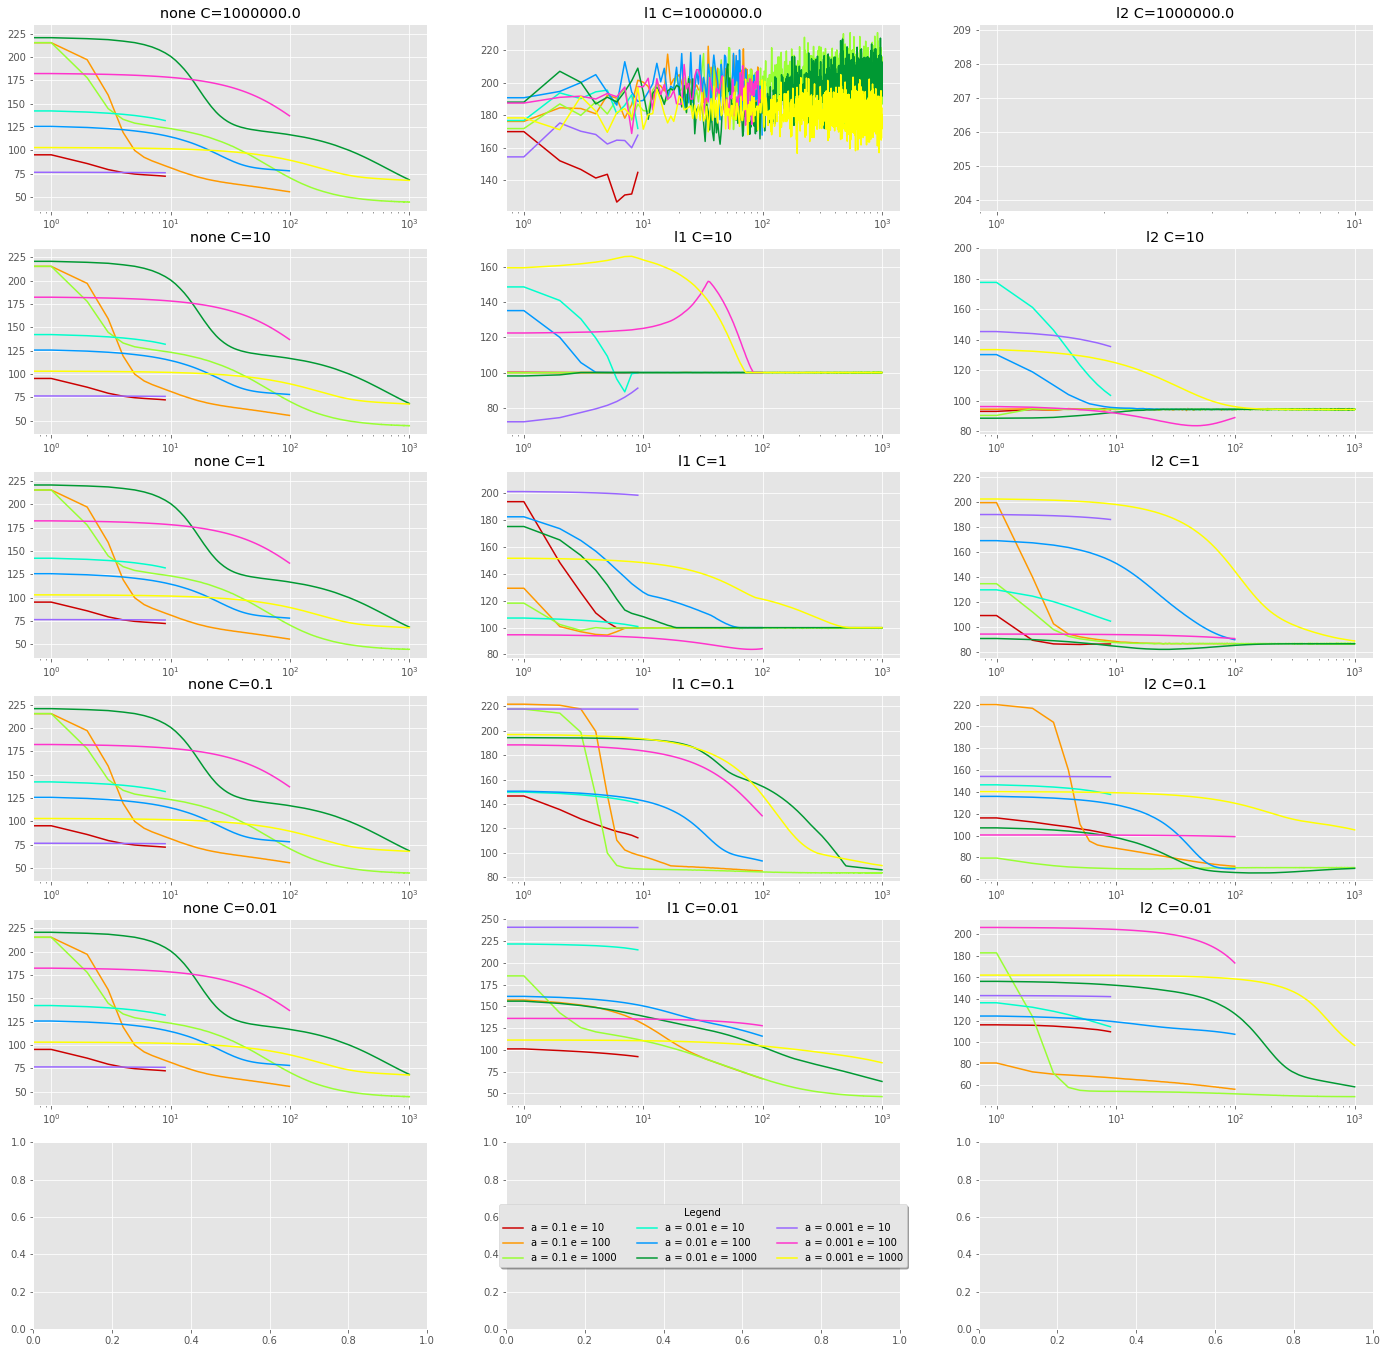

In [56]:
C = [10e5, 10, 1, 0.1, 10e-3]
reg = ['none', 'l1', 'l2']
alpha = [0.1, 0.01, 0.001]
max_epoch = [10, 100, 1000]
colors = ['#cc0000', '#ff9900', '#99ff33', '#00ffcc',
          '#0099ff', '#009933', '#9966ff', '#ff33cc', '#ffff00']

fig, ax = plt.subplots(len(C)+1, len(reg), figsize=(24, 24)) # +1 для легенды

none_model = {}
set_model = False
lines = []

for i, _C in enumerate(C):
    print('draw for C=', _C)
    for j, _reg in enumerate(reg):
        print('draw for reg=', _reg)
        c = 0
        for _alpha in alpha:
            for _max_epoch in max_epoch:
                plt_y = None
                if _reg == 'none':
                    model = MySGDClassifier(
                        C=0, max_epoch=_max_epoch, alpha=_alpha, penalty='l2')
                    key = str(_alpha) + '_' + str(_max_epoch)
                    try:
                        plt_y = none_model[key] # мы же не хотим пересчитывать для С=0
                    except KeyError:
                        set_model = True
                else:
                    model = MySGDClassifier(
                        C=_C, max_epoch=_max_epoch, alpha=_alpha, penalty=_reg)
                if plt_y is None:
                    model.fit(X, y)
                    plt_y = model.rss.copy()
                if set_model:
                    set_model = False
                    none_model[key] = plt_y
                plt_x = np.arange(len(plt_y))
#                 plt_x = np.linspace(0, 1000, num=len(plt_y))
                # логарифмическая шкала для х
                line, = ax[i, j].semilogx(plt_x, plt_y, label='a = '+str(_alpha) +
                                      ' e = ' + str(_max_epoch), color=colors[c])
                lines.append(line)
                ax[i, j].set_title(_reg + ' C='+str(_C))
                c += 1

ax[len(C), 1].legend(handles=lines[:9], loc="center",
                     ncol=3, shadow=True, title="Legend")